In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

In [3]:
df = pd.read_csv("Pairwise Cluster Comparisons - FINAL.txt", sep="\t")

In [19]:
# Summary of miRNA length in DIANA-microT-CDS database
df["Len1"] = df["Sequence_miRNA1"].str.len()
df["Len2"] = df["Sequence_miRNA2"].str.len()

all_lengths = pd.concat([df["Len1"], df["Len2"]])

print("Minimum sequence length:", all_lengths.min())
print("Maximum sequence length:", all_lengths.max())
print("Median sequence length:", all_lengths.median())

Minimum sequence length: 16
Maximum sequence length: 28
Median sequence length: 22.0


In [4]:
# Filter to HRC1_8
fam_1_8_df = df[df["Family_1_8"] == "Yes"].copy()

In [5]:
def count_outside_seed_matches(seq1, seq2):
    return sum(1 for a, b in zip(seq1[8:22], seq2[8:22]) if a == b)

In [6]:
fam_1_8_df["Outside_Seed_Match_Count"] = fam_1_8_df.apply(
    lambda row: count_outside_seed_matches(row["Sequence_miRNA1"], row["Sequence_miRNA2"]), axis=1
)

match_counts = fam_1_8_df["Outside_Seed_Match_Count"].value_counts().sort_index()

full_counts = pd.Series(0, index=range(0, 15))
full_counts.update(match_counts)

result_df = full_counts.reset_index()
result_df.columns = ["Matching Bases Outside 1-8", "Pair Count"]

result_df #Number of matching bases for position 9-22; number of miRNA pairs with the corresponding match number

,Matching Bases Outside 1-8,Pair Count
0,0,3
1,1,11
2,2,23
3,3,37
4,4,35
5,5,30
6,6,23
7,7,31
8,8,41
9,9,55


In [7]:
regression_data = fam_1_8_df.dropna(subset=["Outside_Seed_Match_Count", "Jaccard"]).copy()
model = smf.ols("Jaccard ~ Outside_Seed_Match_Count", data=regression_data).fit()

# Output regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Jaccard   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     440.1
Date:                Fri, 20 Jun 2025   Prob (F-statistic):           3.27e-76
Time:                        14:06:07   Log-Likelihood:                 651.54
No. Observations:                 703   AIC:                            -1299.
Df Residuals:                     701   BIC:                            -1290.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [13]:
fam_1_8_df["Family"] = "HRC1_8" #change Family to Homology Region Class
plot_df = fam_1_8_df[["Family", "Outside_Seed_Match_Count", "Jaccard"]].dropna()

Save plot as PNG? (yes/no):  no


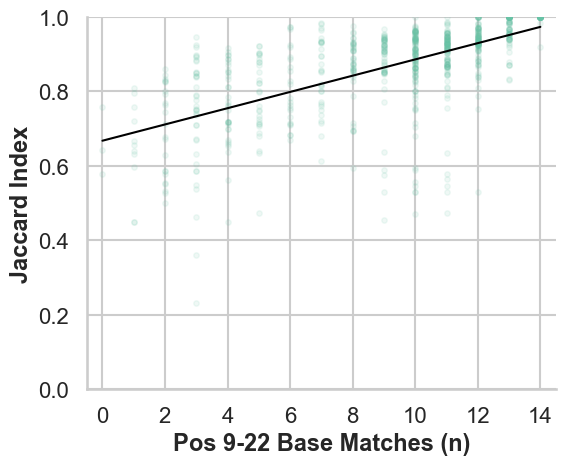

In [15]:
sns.set(style="whitegrid", context="talk")

# seaborn.lmplot uses OLS linear model by default
g = sns.lmplot(
    data=plot_df,
    x="Outside_Seed_Match_Count",
    y="Jaccard",
    height=5,
    aspect=1.2,
    scatter_kws={"alpha": 0.1, "s": 15, "color": "#66c2a5"},  
    line_kws={"color": "black", "linewidth": 1.5},            
    ci=None
)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Number of Matching Bases Outside Seed (9–22)", "Jaccard Index")
g.set(ylim=(0, 1), xlim=(-0.5, 14.5))
for ax in g.axes.flatten():
    ax.set_xticks(range(0, 15, 2))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel("Pos 9-22 Base Matches (n)", fontsize=17, fontweight="bold")
    ax.set_ylabel("Jaccard Index", fontsize=17, fontweight="bold")

plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("jaccard_scatterplot_F1_8_outside_seed.png", dpi=300, bbox_inches='tight')
    print("Plot saved as jaccard_scatterplot_F1_8_outside_seed.png")

plt.show()

In [17]:
regression_data = fam_1_8_df.dropna(subset=["Outside_Seed_Match_Count", "Jaccard"]).copy()

# Compute Pearson correlation coefficient and p-value
r, p_value = pearsonr(regression_data["Outside_Seed_Match_Count"], regression_data["Jaccard"])

print(f"Pearson r: {r:.3f}")
print(f"p-value: {p_value:.2e}")

Pearson r: 0.621
p-value: 3.27e-76
